In [1]:
# numpy and pandas for data manipulation
import sys
# Suppress warnings
import warnings
import seaborn as sns
import matplotlib as plt
import networkx as nx
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
from openml import setups, flows
from __future__ import unicode_literals
import os
import matplotlib2tikz
plt.style.use('seaborn')
sns.set(style="whitegrid")
sns.set_style({'grid.color': '.5'})
sns.set_context("paper", font_scale=2, rc={"lines.markersize": 15})
plt.rc('hatch', color='white', linewidth=8)
plt.rcParams.update({
    "font.family": "serif",
     "font.serif": [] ,
      "font.sans-serif": []  })

warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline
ROOT_RESULT_FOLDER = '/Users/bede01/Documents/work/phd-papers/ml-workload-optimization/experiment_results'


SYSTEM_COLOR = sns.color_palette()[0]
BASELINE_COLOR = sns.color_palette()[1]
OTHER_COLOR = sns.color_palette()[2]

WRITE_DIRECTORY_ROOT = \
'/Users/bede01/Documents/work/phd-papers/ml-workload-optimization/papers/images/experiment-results'

output_directory = WRITE_DIRECTORY_ROOT + '/openml/warmstarting'
def create_folder(path):
    if not os.path.exists(os.path.dirname(path)):
        try:
            os.makedirs(os.path.dirname(path))
        except OSError as exc:  # Guard against race condition
            if exc.errno != errno.EEXIST:
                raise
def savefig(filename):
    plt.savefig('{}.pgf'.format(filename), bbox_inches='tight')
    plt.savefig('{}.pdf'.format(filename), bbox_inches='tight')

In [2]:
TICK_LABEL_SIZE = 34
AXIS_FONT = 40
LW = 8

In [3]:
MODE = 'local'
result_folder = ROOT_RESULT_FOLDER + '/' + MODE + '/warmstarting/openml'
result_file = result_folder + '/2020-02-12/19-44.csv'

In [4]:
HEADERS = [
    'timestamp', 'exp_id', 'repo', 'pipeline', 'setup', 'type', 'warmstart', 'mat_budget','score', 'total_run_time'
]

method_map = {'optimized': 'CO', 'baseline': 'OML'}
execution_times = pd.read_csv(result_file, header=None, names=HEADERS)

execution_times['cumulative_run_time'] = execution_times.groupby(['exp_id', 'type','mat_budget'])['total_run_time'].apply(lambda x: x.cumsum())
execution_times['mat_budget'] = execution_times['mat_budget'] / (1024. * 1024.)
execution_times['workload'] = execution_times.groupby(['exp_id', 'type','mat_budget']).cumcount() + 1
execution_times['type'] = execution_times['type'].replace(method_map)
execution_times['score_mean'] = execution_times['score'].expanding().mean()


In [5]:
execution_times['type'] = ['CO+W' if (x['type'] == 'CO') and (x['warmstart'] == True) else x['type'] for i,x in execution_times[['type','warmstart']].iterrows()]

In [6]:
execution_times['type'] = ['CO-W' if (x['type'] == 'CO') and (x['warmstart'] == False) else x['type'] for i,x in execution_times[['type','warmstart']].iterrows()]

In [7]:
df = execution_times[execution_times.type !='CO-W']

In [8]:
df_CO = execution_times[execution_times.type =='CO+W'][['workload','pipeline','setup','score']][:2000]
df_OML = execution_times[execution_times.type =='OML'][['workload','pipeline','setup','score']][:2000]

In [9]:
diff = df_CO.merge(df_OML, on=['workload','setup'], suffixes=('_CO','_OML'))
diff['diff'] = diff.score_CO - diff.score_OML
diff['cum_diff'] = diff['diff'].cumsum()
diff['constant'] = 1

In [10]:
diff['cum_mean'] = diff['diff'].expanding().mean()

In [18]:
def plot_accuracy(df,loc=None):
    plt.figure(figsize=(8,4))
    plot = sns.lineplot(
        data=df,
        x='workload',
        y='cum_diff',
        lw=LW,
        hue='constant',
        #style='type',
        #ci='sd',
        #hue_order=['CO+W','OML','CO-W'],
#         dashes={
#             'CO+W': (1, 0),
#             'OML': (1, 1),
#             'CO-W': (4, 4),
#         },
        palette={
            1: SYSTEM_COLOR
        },
        legend='brief')
    
#     legend = plt.legend(
#         loc='upper left',
#         handletextpad=0.1,
#         labelspacing=0.0,
#         bbox_to_anchor=(-.08, 1.3))
#     legend.texts[0].set_text("")
#     for line in legend.get_lines():
#         line.set_linewidth(3.0)
        
    plot.set_xlabel('OpenML Workload', fontsize=AXIS_FONT)
    plot.set_ylabel('Cumulative \nΔ Accuracy', fontsize=AXIS_FONT)
    plt.tick_params(labelsize=TICK_LABEL_SIZE)
    legend = plt.legend()
    handles = legend.legendHandles
    labels = ['Δ = acc(CO+W) - acc(OML)']
    del handles[0]

    from matplotlib.lines import Line2D
#     handles[0] = Line2D([0], [1],
#                         color=SYSTEM_COLOR,
#                         linewidth=LW-2,
#                         dashes=(1, 0))
#     handles[1] = Line2D([0], [1],
#                         color=OTHER_COLOR,
#                         linewidth=LW-2,
#                         dashes=(1, 1))
    
#     handles[2] = Line2D([0], [1],
#                         color=BASELINE_COLOR,
#                         linewidth=LW-2,
#                         dashes=(4, 4))
    
    legend = plt.legend(
        handles,
        labels,
        loc='upper center',
        handlelength=1.8,
        handletextpad=0.05,
        fontsize=TICK_LABEL_SIZE,
        numpoints=1,
        ncol=3,
        columnspacing=0.2,
        bbox_to_anchor=(0.47, 1.29))
    legend.legendHandles[0].set_visible(False)
    plot.set_yticks([0, 10, 20,30])
    plot.set_xticks([0, 500, 1000, 1500, 2000])
    #plot.yaxis.set_major_formatter(ticker.EngFormatter(sep=''))


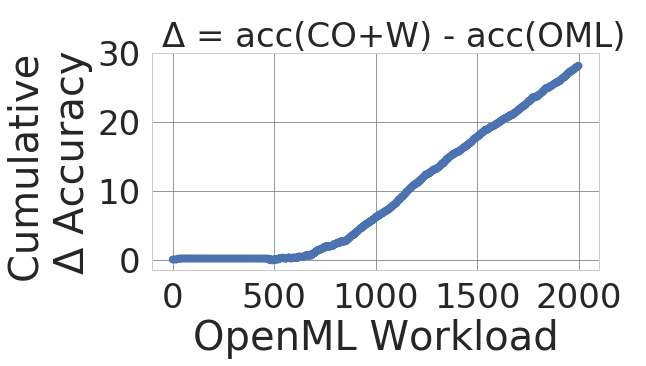

In [20]:
plot_accuracy(diff)
savefig(output_directory+'/accuracy')

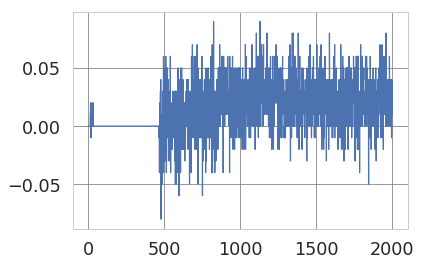

In [13]:
plt.plot(diff['diff'])


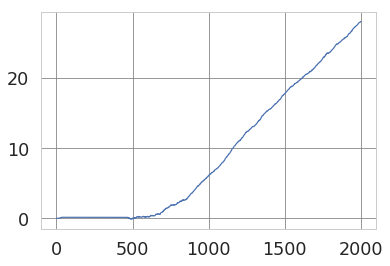

In [14]:
plt.plot(diff['diff'].cumsum()) # 99

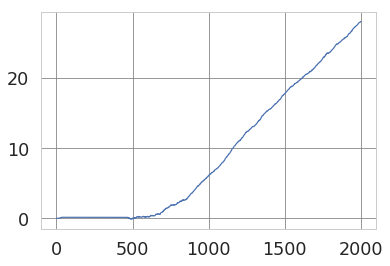

In [15]:
plt.plot(diff['diff'].cumsum()) # 98

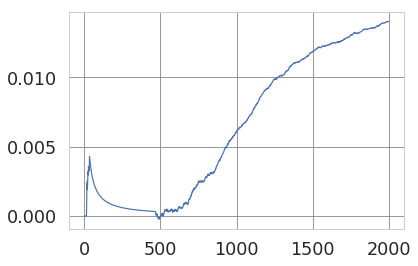

In [16]:
plt.plot(diff['diff'].expanding().mean()) # 98

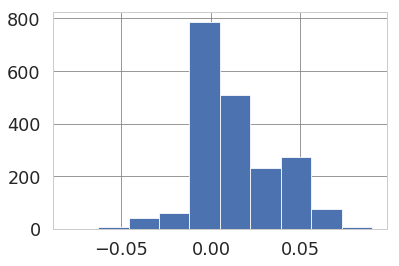

In [17]:
diff['diff'].hist()